# Tutorial: Diffusion Map Embedding & Label Transfer with **acdc_py**

A **diffusion map** is a powerful nonlinear dimensionality reduction technique, particularly useful for capturing intrinsic structures in single-cell data. It's often used for visualization and pre-processing, especially when analyzing dynamic biological processes or subtle differences between cell states.

In many applications, we may have **reference single-cell data**—for example, from healthy tissue—and want to compare it to **query data**, such as cells from a diseased condition. A key question is: *how similar are the query cells to the reference cells in various embedding spaces, such as PCA, UMAP, or diffusion maps?*

Once both datasets are aligned in a common space, we can perform **label transfer**, propagating known annotations (e.g. cell types) from the reference to the query data. While **Scanpy’s `ingest`** function supports mapping and label transfer in PCA/UMAP space, it does not support **diffusion maps**, and its all-in-one design makes it hard to control mapping and label transfer independently.

**AC/DC** addresses these limitations by providing:
- `acdc_py.run_diffusion_map`: a flexible diffusion map implementation with support for **Nyström extension** (query mapping)
- `acdc_py.transfer_labels_anndata`: a modular, standalone **label transfer method** that can operate in any space, including the mapped diffusion space or PCA.

Both methods work with reference and query AnnData objects.

---

## In this hands-on tutorial, we’ll explore how to:

0. **Use AC/DC to identify the optimal clusters** in your single-cell dataset of interest 
1. **Set up reference and query data** needed for diffusion map computation and reference mapping
2. **Compute diffusion map embeddings** on the reference data
3. **Project new (query) cells** onto the reference data via the Nyström extension  
4. **Transfer cell-type labels** learned with AC/DC using a KNN classifier in the learned reference + mapped query space (diffusion space or PCA space)
5. **Evaluate the accuracy** of the label transfer method when ground truth labels for the query are available.

---

**Prerequisites:**  
- An environment with `acdc_py` installed  

Let’s get started!


## 1. Suppress Warnings
To keep output clean, we’ll hide non‑critical Python warnings that might clutter the notebook.

In [1]:
import warnings
# Hide non-critical warnings for a cleaner notebook output
warnings.filterwarnings("ignore")

## 2. Import Required Libraries
We’ll load standard data‑science packages, Scanpy for single‑cell analysis, our `acdc_py` toolkit, and a utility to split data into training and test sets.

In [2]:
import numpy as np # Numerical computing
import scanpy as sc      # Single‑cell analysis framework
import acdc_py as acdc   # Our diffusion map & label‑transfer toolkit
from sklearn.model_selection import train_test_split  # Train/test splitting

## 3. Load Gene Expression Data
Load a dataset from the EBI Single Cell Expression Atlas <https://www.ebi.ac.uk/gxa/sc/experiments>. We also subset the resulting AnnData to make the processing faster. We will only retain 2 out of 10 biological replicates, and randomly select 30% of the cells left for the purpose of this tutorial.

In [3]:
adata = sc.datasets.ebi_expression_atlas(accession="E-GEOD-167266")
adata

100%|██████████| 18.5M/18.5M [00:01<00:00, 12.1MB/s]
240MB [00:45, 5.58MB/s] 


AnnData object with n_obs × n_vars = 48228 × 14690
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[strain]', 'Sample Characteristic Ontology Term[strain]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[genotype]', 'Sample Characteristic Ontology Term[genotype]', 'Factor Value[replicate]', 'Factor Value Ontology Term[replicate]', 'Factor Value[inferred cell type - ontology labels]', 'Factor Value Ontology Term[inferred cell type - ontology labels]', 'Factor Value[inferred cell type - authors labels]', 'Factor Value Ontology Term[inferred cell type - authors labels]'

In [4]:
# Check how many cells are in each biological replicate with .value_counts
adata.obs['Factor Value[replicate]'].value_counts()
# This dataset has 10 biological replicates
# We will select the first 2 replicates to allow for faster processing


Factor Value[replicate]
wild type third instar larval optic lobe rep 2     7829
wild type third instar larval optic lobe rep 1     6675
wild type third instar larval optic lobe rep 3     6640
wild type third instar larval optic lobe rep 8     5243
wild type third instar larval optic lobe rep 10    4617
wild type third instar larval optic lobe rep 5     4348
wild type third instar larval optic lobe rep 4     4068
wild type third instar larval optic lobe rep 6     3905
wild type third instar larval optic lobe rep 7     2976
wild type third instar larval optic lobe rep 9     1927
Name: count, dtype: int64

In [5]:
# We select the first 2 biological replicates
replicates_to_keep = adata.obs['Factor Value[replicate]'].value_counts().index[:2]
adata = adata[adata.obs['Factor Value[replicate]'].isin(replicates_to_keep), :].copy()

N = 30# Retain only N% of the observations, randomly chosen, for demonstration purposes
np.random.seed(42)  # Set the seed for reproducibility
observations_to_keep = np.random.choice(adata.obs_names, size=int(len(adata) * N / 100), replace=False)
adata = adata[observations_to_keep, :].copy()

## 4. Basic Preprocessing  
Filter lowly‑expressed genes, normalize counts, log‑transform, and scale features.


In [6]:
# Remove genes expressed in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# Normalize each cell to total count = 1e4, then log1p
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Scale to unit variance and clip extreme values at ±10
sc.pp.scale(adata, max_value=10)

## 5. Select Highly Variable Genes  
To focus on informative features, we’ll keep the top 2,000 most variable genes.


In [7]:
# Identify and subset to the 2,000 most variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True
)

### 6. Visualize Data Colored by Replicate in UMAP

This plot helps us assess potential **batch effects** or differences between biological replicates. If strong replicate-specific patterns are present, they may negatively impact the quality of query-to-reference mapping.

In the example below, no major batch effects are observed — suggesting that the two replicates are well-aligned and suitable for joint analysis.


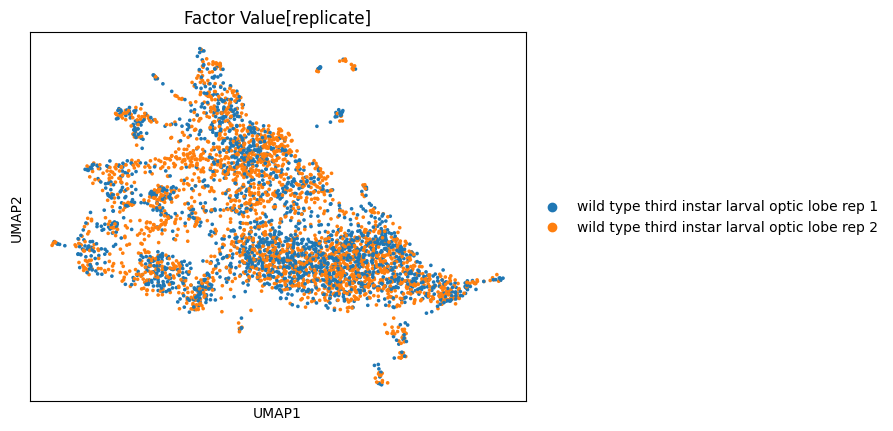

In [8]:
# Dimensionality reduction via PCA -- required for AC/DC algorithm
sc.pp.pca(adata)
# Build k-NN graph on PCs
sc.pp.neighbors(adata)
# Compute UMAP coordinates of gene epression data
sc.tl.umap(adata) 
sc.pl.umap(adata, color=["Factor Value[replicate]"])

## 7. Run AC/DC Clustering and Visualize Results

To enable label transfer, we first need labels for the reference dataset. These labels can represent biological categories such as **cell types** or **states**.

Since such annotations may not be available a priori, we use **AC/DC’s clustering module** to infer them. AC/DC performs an automated **grid search** to identify an optimal clustering solution — without requiring the number of clusters to be specified in advance.

In this example, AC/DC operates on the **PCA-transformed data**, so PCA must be computed beforehand (as done in Step 6).  
While other representations can be used via the `reduction_slot` parameter, we recommend **PCA** for its speed and robust performance.


Computing distance object...


100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


Computing neighbors...


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Beginning GridSearch clustering...


GridSearch: 100%|██████████| 39/39 [00:28<00:00,  1.35it/s]


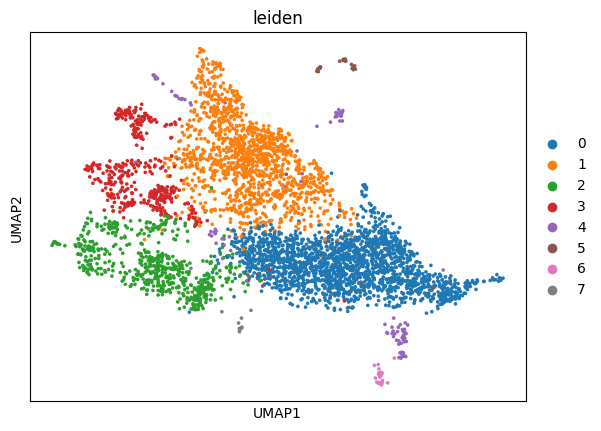

In [9]:
acdc.config.set_clust_alg(clust_alg='Leiden')
acdc.config.set_corr_distance_dtype(dtype=np.float64)
acdc.GS(
    adata,
    reduction_slot="X_pca", #uses previously computed PCA coordinates
    metrics=['sil_mean', 'sil_mean_median'],
    opt_metric="sil_mean_median",
    njobs=1,
    NN_vector=[15],
    res_vector=np.arange(0.05, 2.0, step=0.05),
    dist_slot=None,
    key_added="leiden"
)

# Plot UMAP colored by 1) the replicate number and 2) the Leiden clustering
sc.pl.umap(adata, color=["leiden"])

## 8. Create Reference and Query AnnData Objects

To map query cells onto the diffusion space of reference cells, we first need to define which cells belong to each group.

Since our dataset includes two biological replicates, we can simulate a common use case by treating one replicate as the **reference** and the other as the **query**. This setup allows us to test how well label transfer performs across experimental batches.

Importantly, the query cells already have cluster labels from the previous step. We'll preserve these as **ground truth** in a new `.obs` column (`true_leiden`), which we’ll later use to evaluate label transfer accuracy.  
To mimic a real-world scenario—where query cell labels are unknown—we’ll remove the original `"leiden"` column from the query AnnData.

In [10]:
# Create reference and query AnnData by subsetting to the two replicates
ref_adata = adata[adata.obs['Factor Value[replicate]'] == replicates_to_keep[0], :].copy()
query_adata = adata[adata.obs['Factor Value[replicate]'] == replicates_to_keep[1], :].copy()
print(f"ref adata shape: {ref_adata.shape}")
print(f"query adata shape: {query_adata.shape}")

ref adata shape: (2337, 2000)
query adata shape: (2014, 2000)


In [11]:
# Save ground truth labels for the query AnnData in a "true_leiden" column
query_adata.obs["true_leiden"] = query_adata.obs["leiden"].copy()
# Remove the original "leiden" column to simulate absence of ground truth labels
del query_adata.obs["leiden"]

# Display query AnnData summary
query_adata


AnnData object with n_obs × n_vars = 2014 × 2000
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[strain]', 'Sample Characteristic Ontology Term[strain]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[genotype]', 'Sample Characteristic Ontology Term[genotype]', 'Factor Value[replicate]', 'Factor Value Ontology Term[replicate]', 'Factor Value[inferred cell type - ontology labels]', 'Factor Value Ontology Term[inferred cell type - ontology labels]', 'Factor Value[inferred cell type - authors labels]', 'Factor Value Ontology Term[inferred cell type - authors labels]', 'true_leiden'
    var: 'n_cells', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

## 9. Compute Diffusion Map & Nyström Extension

In this step, we compute a **diffusion map embedding** on the reference dataset, and then **project the held-out query cells** into the same diffusion space using the **Nyström extension** method. This enables consistent visualization and downstream analysis of both datasets in a shared low-dimensional space.

The `acdc.run_diffusion_map()` function offers several tunable parameters:

- **`embedding_key="X"`**  
  Specifies the input representation used to compute the diffusion map.  
  Use `"X"` to apply the method directly to `.X`, or provide the name of a custom representation stored in `.obsm`.

- **`neigen=10`**  
  Number of diffusion components (dimensions) to compute. These serve as the coordinates in the resulting diffusion space.

- **`pca_comps=None`**  
  *(Optional)* Number of principal components to use for preprocessing before constructing the diffusion map.  
  Reducing dimensionality via PCA can significantly speed up computation, at the potential cost of minor loss in mapping accuracy.

- **`k=None`**  
  *(Optional)* Number of nearest neighbors to consider when building the affinity matrix.  
  If provided, a sparse k-NN graph is used instead of the full pairwise distance matrix. Use together with a X_pca embedding key or other lower dimensional spaces to speed up computation on larger datasets.

- **`plot=True`:** 
*(Optional)* You can visualize the reference and query cells together in the resulting diffusion space by setting to `True`.

> **Note:** Applying PCA and/or using a reduced number of neighbors (K) can make 2D diffusion maps less visually clear, while the label transfer performance positively or negatively. PCA reduces the computation time for generating the reference diffusion map. Using K further speeds up the process, but only if PCA is also applied—otherwise, computation time may increase significantly. For large datasets, using both PCA and may K greatly reduce run time.

Computing diffusion map (10 components) on reference...
Extending to query via Nyström extension...


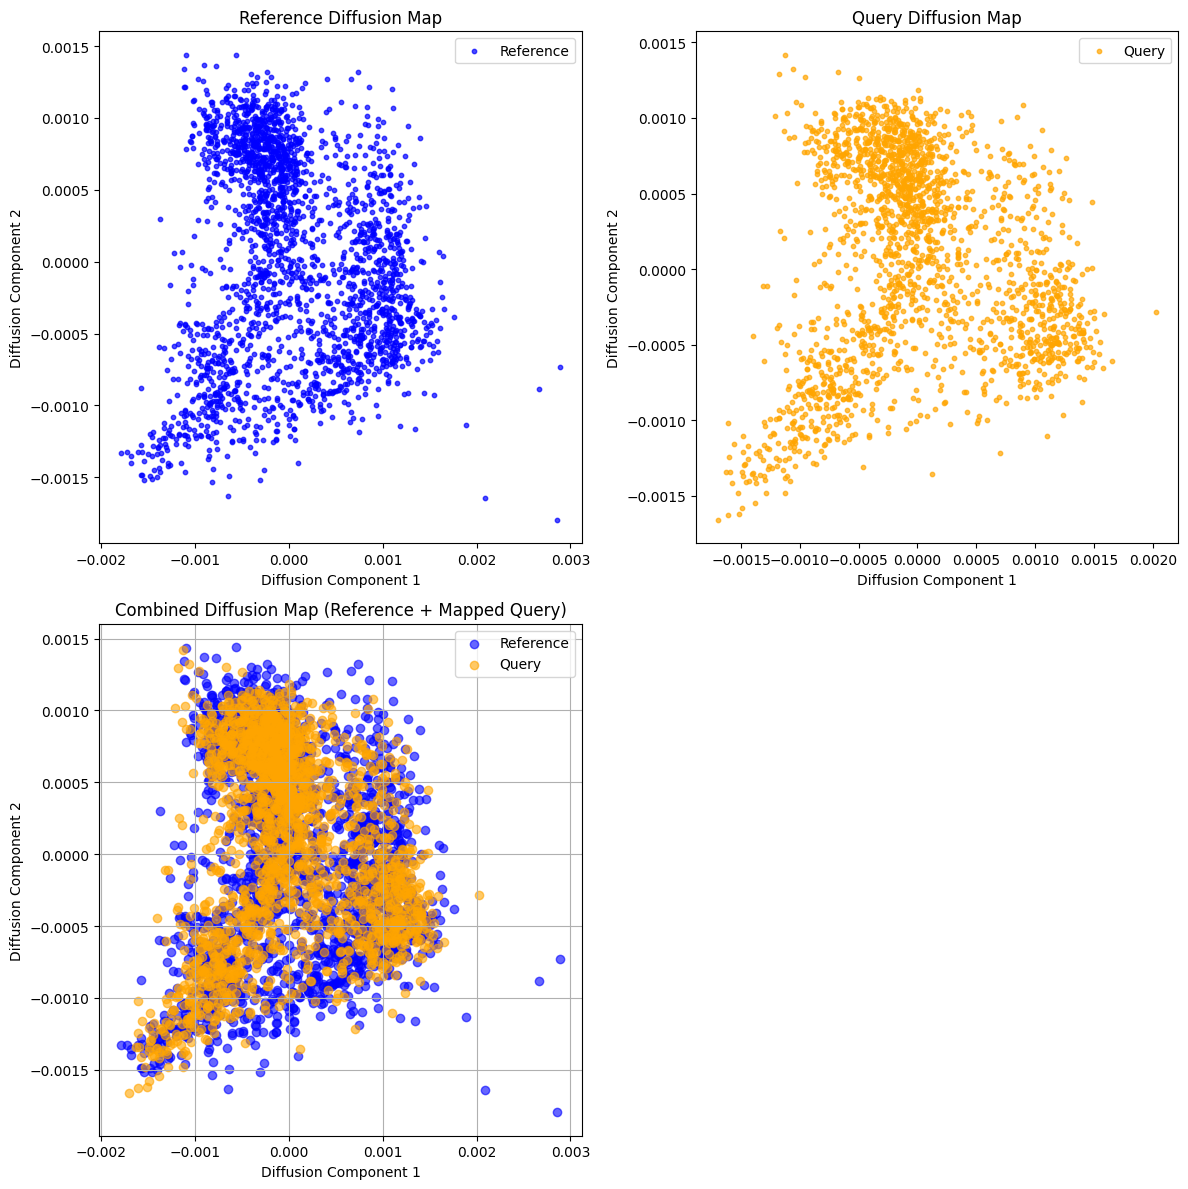

Stored embeddings in .obsm['X_diffmap'] and details in .uns['diffusion_results'].


In [12]:
acdc.run_diffusion_map(
    ref_adata, # Reference AnnData    
    query_adata, # Query AnnData
    embedding_key="X", # Input reference representation to the diffusion map dimensionality reduction.
    neigen=10, # Number of output dimensions in diffusion space         
    pca_comps=None, # Number of PCA components to apply to input data before running diffusion map     
    k=None, # Number of neighbors to use in the diffusion map graph affinity matrix. Use together with PCA to speed up computation.         
    plot=True # Whether to plot the reference+mapped query 2D diffusion coordinates or not          
)

### Interpreting the Diffusion Map Plot

Here, we visualize the first two diffusion components, showing reference and query cells separately (first row) and in the same low-dimensional space (second row). This allows us to inspect how well the query cells were mapped to the reference structure.

However, this is only the **first step** in evaluating mapping quality. The **next step** is to check whether the transferred labels on the query match their original (ground truth) labels — providing a more objective measure of alignment accuracy.


## 10. Transfer Labels from Reference to Query

Once the query cells have been mapped into a common embedding space (e.g. diffusion map or PCA), we can transfer labels from the reference dataset using a **K-nearest neighbors classifier**.

The `acdc.transfer_labels_anndata()` function performs this label transfer and optionally evaluates prediction accuracy if ground-truth labels are available.

### Key Parameters:

- **`embedding_key="X_diffmap"`**  
  Specifies the space in which to perform KNN label transfer. Only `X_diffmap`, `X_pca` or `X` are supported, which correspond to the diffusion map space, PCA space, or the original gene expression space. We suggest to use either `X_diffmap` or `X_pca` for speed and performance.

- **`pca_comps=None`**  
  *(Optional)* Number of PCA components to compute before label transfer. If a number is provided, and the embedding key is set on `X_pca`, PCA will be computed de novo on the reference using specified components and query cells will be mapped onto the reference using the PCA loadings (components) before running label transfer. If left as `None`, the function expects `X_diffmap` or `X` as the embedding key. This argument will be ignored unless the embedding key is set on `X_pca`.

- **`label_key="leiden"`**  
  The key in `ref_adata.obs` that contains the labels to transfer (e.g., cell clusters or types).

- **`n_neighbors=15`**  
  The number of neighbors used in the KNN classifier.

- **`ground_truth_label="true_leiden"`**  
  *(Optional)* If provided, the accuracy of transferred labels is computed by comparing them to known labels in `query_adata.obs[ground_truth_label]`.

- **`plot_labels=True`**  
  Visualizes the predicted vs. ground-truth labels using the selected embedding.

> **Tip:** This function is modular and works with **any shared embedding** (e.g., PCA, diffusion map, or UMAP), giving you full control over when and how mapping and label transfer


Labels transferred to query .obs['leiden'] using X_diffmap embedding.
Accuracy against 'true_leiden': 0.93


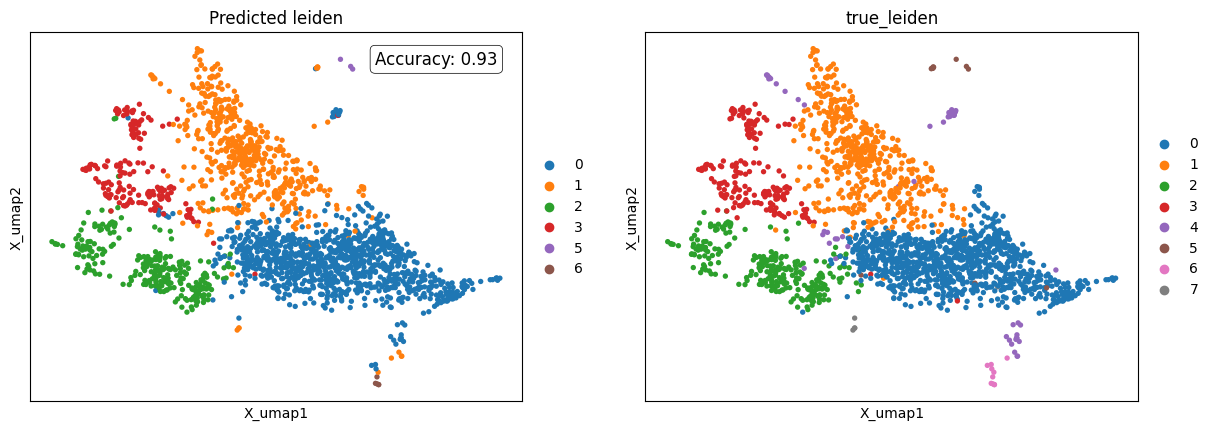

In [13]:
acdc.transfer_labels_anndata(
    ref_adata=ref_adata, # Reference AnnData            
    query_adata=query_adata, # Query AnnData
    embedding_key='X_diffmap', # Either X_pca, X_diffmap, or X  
    pca_comps=None, # Use with embedding_key='X_pca' to run query to ref mapping using PCA                 
    label_key='leiden', # Label key in reference AnnData              
    n_neighbors=15, # k in k-NN classifier. Determines the resolution of the label transfer.                
    ground_truth_label="true_leiden", # If ground truth available, it will be used to assess label transfer accuracy
    plot_labels=True, # Plot ground truth and predicted labels of the query if ground truth is available
    plot_embedding_key="X_umap"  # Choose the representation for plotting the query AnnData        
)

### Interpreting Label Transfer Outcomes 

We can assess the quality of the query-to-reference mapping in two ways:

- **Qualitatively**, by visually comparing the predicted labels (transferred from the reference) with the ground truth labels on the UMAP plot.
- **Quantitatively**, by reviewing the printed accuracy score.

In this example, label transfer was performed in the **diffusion map space**, resulting in an **accuracy of 93%**. This means that out of every 100 query cells, 93 were assigned the correct cluster label based on their position in the mapped space.
